# [AudioMNIST](https://github.com/soerenab/AudioMNIST/tree/master/data) Classification

This is a simple idea and implement that feeds a convolution network with spectral of reconstruction signal from audio signal's empirical decomposition for classification, which basically filters the low-frequency components adaptively for reducing the tone variance, while staying the pronunciation features to get an easy fit and better performance. It took 5 epochs and got 95% accuracy during several experiments.

**References:**
1. [Interpreting and Explaining Deep Neural Networks for Classification of Audio Signals. S. Becker, M. Ackermann, S. Lapuschkin, K.R. Müller, and S. Wojciech. ArXiV preprint. 2018](https://arxiv.org/abs/1807.03418)
2. [Audio Deep Learning Made Simple: Sound Classification, Step-by-Step, K. Doshi. Towards Data Science. 2021.](https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5)
3. [Audio MNIST Classification, Kyle R. Chickering](https://www.kaggle.com/code/kyrobc/audio-mnist-classifier-with-98-accuracy-15-min/notebook)

In [17]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
from scipy.io import wavfile as wv
import torch
import torch.nn as nn
import emd
from tqdm import tqdm
DATAPATH = './data/'

In [18]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

#### Loading the Data into a Torch Tensor
All of the samples are sampled at 48kHZ, and the samples are all less than one second. We load the data into one second intervals and pad the difference with leading silence.

In [3]:
def load_audio_MNIST(n_speakers=60):
    """ Build a dataframe out of the .wav files. """
    if n_speakers > 60:
        raise Exception("Only 60 speakers")
        
    X = torch.zeros(50 * n_speakers * 10, 48000)
    y = torch.zeros(50 * n_speakers * 10, 10)
    
    sample = 0
    for ii in range(1, n_speakers + 1):
        num = "0%d" % ii if ii < 10 else "%d" % ii
        
        for jj in range(50):
            for kk in range(10):
                _, audio = wv.read(DATAPATH + num + "/%d_%s_%d.wav" % (kk, num, jj))
                audio = torch.Tensor(audio)
                X[sample, -audio.shape[0]:] = audio / torch.max(torch.abs(audio))
                y[sample, kk] = 1 # the number spoken
                sample += 1

    return X, y

#### Preprocessing Pipeline
We firstly reconstruct the original signal from low index modes of empirical decomposition.

Then we are going to build 2D sepctrograms from the 1D audio channel, and then use a 2D CNN to learn from these spectrograms.

In [4]:
import random
import torchaudio
from torchaudio import transforms

class AudioHandler():
    @staticmethod
    def open(file_path):
        # throw away sample rate since it is a constant
        # signal, _ = torchaudio.load(file_path)
        fs, signal = sp.io.wavfile.read(file_path)
        # decomposition
        imf = emd.sift.sift(signal)
        # Reconstruction
        signal = np.sum(imf[:, :-4], axis=1)
        return torch.tensor(signal).reshape(1, -1)
    
    @staticmethod
    def pad(signal, audio_length):
        new_signal = torch.zeros((1, audio_length))
        new_signal[0, 48000 - len(signal):] = signal
        
        return new_signal
    
    @staticmethod
    def time_shift(signal, shift_limit):
        """ Data augmentation: shift forward or back by a bit. """
        signal_length = signal.shape[1]
        shift = int(random.random() * shift_limit * signal_length)
        return signal.roll(shift)
    
    @staticmethod
    def spectrogram(signal, n_mels=64, n_fft=2034, hop_len=None):
        top_db = 80
        
        spec = transforms.MelSpectrogram(48000, n_fft=n_fft, 
                                        hop_length=hop_len, 
                                        n_mels=n_mels)(signal)
        spec = transforms.AmplitudeToDB(top_db=top_db)(torch.Tensor(spec))
        
        return spec
    
    @staticmethod
    def spectral_augmentation(spec, max_mask_ptc=0.1, 
                              n_freq_masks=1, 
                              n_time_masks=1):
        """ Augment the spectrogram data. """
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec
        
        freq_mask_param = max_mask_ptc * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(
                freq_mask_param
            )(aug_spec, mask_value)
            
        time_mask_param = max_mask_ptc * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(
                time_mask_param
            )(aug_spec, mask_value)
            
        return aug_spec

#### Constructing the DataSet and DataLoader
The dataset is fairly large and it is actaually more convinent to not store the entire dataset in memory (at least on Kaggle). Instead we create an indexed dictionary of the filenames and load only a batch at a time into memory.

When we create the dataloaders we will use multiple workers which will speed up training since each bactch will be loaded prior to training beginning.

In [5]:
from torch.utils.data import DataLoader, Dataset, random_split

class AudioMNIST(Dataset):
    def __init__(self, load_entire_filetree=False):
        self.files = self._build_files()
        self.audio_len = 48000
        self.shift_ptc = 0.4
        
    def _build_files(self):
        files = {}
        index = 0
        for ii in range(1, 61):
            num = "0%d" % ii if ii < 10 else "%d" % ii
            for jj in range(50):
                for kk in range(10):
                    files[index] = [
                        DATAPATH + num + "/%d_%s_%d.wav" % (
                            kk, num, jj),
                        kk
                    ]
                    index += 1
                    
        return files
    
    def __len__(self):
        return 30000
    
    def __getitem__(self, idx):
        signal = AudioHandler.open(self.files[idx][0])[0]
        pad = AudioHandler.pad(signal, self.audio_len)
        shift = AudioHandler.time_shift(pad, self.shift_ptc)
        sgram = AudioHandler.spectrogram(
            shift, n_mels=64, n_fft=1024, hop_len=None
        )
        aug_sgram = AudioHandler.spectral_augmentation(
            sgram, max_mask_ptc=0.1, n_freq_masks=2, n_time_masks=2
        )
        
        return aug_sgram, self.files[idx][1]

In [6]:
dataset = AudioMNIST()

In [7]:
n_items = len(dataset)
n_train = round(n_items * 0.8)
n_val_test = n_items - n_train
train_ds, val_test_ds = random_split(dataset, [n_train, n_val_test])

n_val = round(n_val_test * 0.6)
n_test = n_val_test - n_val
val_ds, test_ds = random_split(val_test_ds, [n_val, n_test])

train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=64, shuffle=True, num_workers=2
)

val_dl = torch.utils.data.DataLoader(
    val_ds, batch_size=64, shuffle=False, num_workers=2
)

test_dl = torch.utils.data.DataLoader(
    test_ds, batch_size=32, shuffle=False, num_workers=2
)

In [8]:
import torch.nn as nn

class CNN2DAudioClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = []
        
        def build_conv_layer(in_d, out_d, ks, stride, pad):
            conv1 = nn.Conv2d(in_d, out_d, 
                              kernel_size=(ks, ks), 
                              stride=(stride, stride), 
                              padding=(pad, pad))
            relu1 = nn.ReLU()
            bn1 = nn.BatchNorm2d(out_d)
            nn.init.kaiming_normal_(conv1.weight, a=0.1)
            conv1.bias.data.zero_()
            return [conv1, relu1, bn1]
        
        self.conv_layers += build_conv_layer(1, 8, 5, 2, 2)
        self.conv_layers += build_conv_layer(8, 16, 3, 2, 1)
        self.conv_layers += build_conv_layer(16, 32, 3, 2, 1)
        self.conv_layers += build_conv_layer(32, 64, 3, 2, 1)
        
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)
        
        self.conv = nn.Sequential(*self.conv_layers)
        
    def forward(self, x):
        x = self.conv(x)
        
        x = self.ap(x)
        x = x.view(x.shape[0], -1)
        
        return self.lin(x)

In [9]:
def evaluate(model, val_dl): 
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0
        
    for data in tqdm(val_dl):
        inputs, labels = data[0].to(device), data[1].to(device)

        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        optimizer.zero_grad()

        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))

        running_loss += loss.item()

        _, prediction = torch.max(outputs, 1)
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

    num_batches = len(val_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction / total_prediction

    return acc, avg_loss

In [10]:
def training(model, train_dl, val_dl, num_epochs, 
             criterion, optimizer, scheduler):
    losses = []
    val_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        
        for data in tqdm(train_dl):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            
            optimizer.zero_grad()
            
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            running_loss += loss.item()
            
            _, prediction = torch.max(outputs, 1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
            
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction / total_prediction
        
        v_acc, v_loss = evaluate(model.to(device), val_dl)
        
        print("Epoch: %d, Loss: %.4f, Train Accuracy: %.2f, Val. Loss: %.4f, Val. Accuracy: %.2f" % (
            epoch + 1, avg_loss, acc, v_loss, v_acc
        ))
        
        losses.append(avg_loss)
        val_losses.append(v_loss)
        
    return losses, val_losses

#### Training 

In [11]:
model = CNN2DAudioClassifier().to(device)

In [12]:
N_EPOCHS = 5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=0.001, 
                                                steps_per_epoch=int(len(train_dl)), 
                                                epochs=N_EPOCHS, 
                                                anneal_strategy='linear')

In [13]:
losses, val_losses = training(model, train_dl, val_dl, N_EPOCHS, criterion, optimizer, scheduler)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [02:44<00:00,  2.89s/it]


Epoch: 1, Loss: 1.9438, Train Accuracy: 0.35, Val. Loss: 1.3835, Val. Accuracy: 0.60


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [02:42<00:00,  2.86s/it]


Epoch: 2, Loss: 0.8085, Train Accuracy: 0.79, Val. Loss: 0.4283, Val. Accuracy: 0.90


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [02:42<00:00,  2.86s/it]


Epoch: 3, Loss: 0.3122, Train Accuracy: 0.93, Val. Loss: 0.2384, Val. Accuracy: 0.95


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [02:42<00:00,  2.84s/it]


Epoch: 4, Loss: 0.2037, Train Accuracy: 0.95, Val. Loss: 0.1915, Val. Accuracy: 0.96


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [02:41<00:00,  2.83s/it]

Epoch: 5, Loss: 0.1727, Train Accuracy: 0.96, Val. Loss: 0.1687, Val. Accuracy: 0.96


In [14]:
evaluate(model, val_dl)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [02:42<00:00,  2.86s/it]


(0.9580555555555555, 0.17001804892431227)

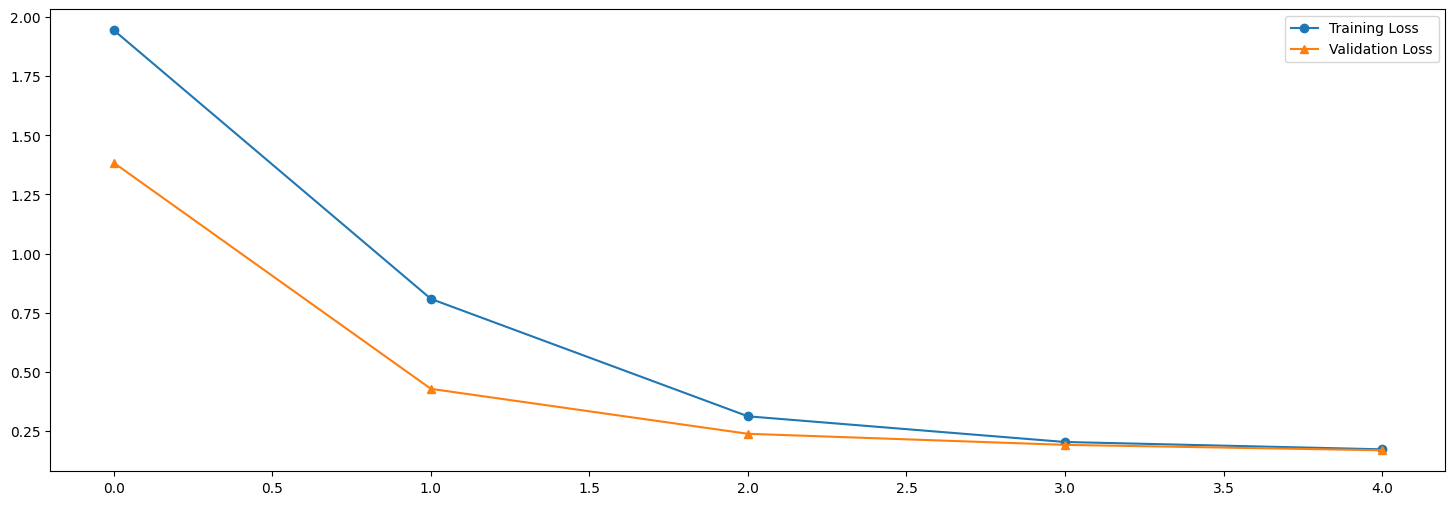

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6))
plt.plot(range(len(losses)), losses, '-o', range(len(val_losses)), val_losses, '-^')
plt.legend(['Training Loss', 'Validation Loss'])
plt.savefig('base.png')
plt.show()

In [16]:
acc, loss = evaluate(model, test_dl)
print("Test accuacy: %.2f, Test loss: %.3f" % (acc, loss))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [01:50<00:00,  1.47s/it]

Test accuacy: 0.95, Test loss: 0.193
